In [1]:
import pachinko
nbatches = 10000
nperevent = 10
depos = pachinko.random_depos(nbatches, nperevent)

def dump_deposet(depos):
    print(depos.shape)
    print("\tx\ty\tq\tsigma")
    for one in depos[:,:]:
        print("".join([f'{t:9.5}' for t in one.unbind()]))
dump_deposet(depos[0])


torch.Size([10, 4])
	x	y	q	sigma
   415.18  -39.859      1.0      0.0
   686.93  -24.774      1.0      0.0
   473.02  -16.509      1.0      0.0
   822.69  -43.809      1.0      0.0
   275.56   39.079      1.0      0.0
   148.13  -47.878      1.0      0.0
   975.66   4.1907      1.0      0.0
   452.09  -2.5748      1.0      0.0
   11.798   28.268      1.0      0.0
   208.14   27.952      1.0      0.0


In [22]:
import torch
true_dt = 0.01
true_lt = 3000.0
drifter = pachinko.Drifter(true_dt, true_lt)
drifter2 = pachinko.Drifter(0.02, 2000.0)
print('Drifter       DT:', drifter.param_dt.item(), drifter.DT.item())
print('Drifter lifetime:', drifter.param_lt.item(), drifter.lifetime.item())
with torch.no_grad():
    drifted = drifter(depos[0])
    drifted2 = drifter2(depos[0])
dump_deposet(drifted)


Drifter       DT: -4.595119953155518 0.009999998845160007
Drifter lifetime: -0.8472977876663208 3000.0
torch.Size([10, 4])
	x	y	q	sigma
      0.0  -39.859  0.12924   2.8816
      0.0  -24.774  0.20465   3.7065
      0.0  -16.509  0.14587   3.0758
      0.0  -43.809  0.23984   4.0563
      0.0   39.079 0.087762   2.3476
      0.0  -47.878 0.048176   1.7212
      0.0   4.1907  0.27763   4.4174
      0.0  -2.5748  0.13989    3.007
      0.0   28.268 0.003925  0.48576
      0.0   27.952 0.067027   2.0403


In [23]:
nwires = 21
pitch = 5.0
span = nwires * pitch
half = 0.5*span
bins = torch.linspace(-half, half, nwires+1)
collector = pachinko.Collector(bins)
with torch.no_grad():
    adcs = collector(drifted)
    adcs2 = collector(drifted2)
print(adcs)
print(adcs2)

tensor([5.3457e-02, 1.6915e-01, 1.7505e-01, 1.9611e-02, 3.0236e-02, 1.3507e-01,
        8.5784e-02, 9.4361e-02, 6.2325e-03, 7.4920e-02, 1.4400e-01, 1.5696e-01,
        3.9101e-02, 1.0831e-03, 8.1726e-06, 2.5314e-02, 4.5582e-02, 1.5051e-02,
        7.1034e-02, 1.7280e-03, 2.2352e-08])
tensor([9.8170e-02, 2.1246e-01, 2.2092e-01, 6.2358e-02, 6.3689e-02, 1.5048e-01,
        1.4448e-01, 1.1887e-01, 3.1770e-02, 1.1676e-01, 2.0031e-01, 1.7213e-01,
        7.6099e-02, 1.1082e-02, 8.6687e-04, 4.0720e-02, 6.2681e-02, 3.3221e-02,
        8.7101e-02, 9.3182e-03, 2.1607e-05])


In [13]:
reality = pachinko.make_model(0.1, 3000.0, pitch, nwires)
drifter, collector = reality.children()
print(drifter.DT, drifter.lifetime)
print(collector.binning)
print(collector.binning.shape, adcs.shape)

tensor(0.1000, grad_fn=<AddBackward0>) tensor(3000., grad_fn=<AddBackward0>)
tensor([-52.5000, -47.5000, -42.5000, -37.5000, -32.5000, -27.5000, -22.5000,
        -17.5000, -12.5000,  -7.5000,  -2.5000,   2.5000,   7.5000,  12.5000,
         17.5000,  22.5000,  27.5000,  32.5000,  37.5000,  42.5000,  47.5000,
         52.5000])
torch.Size([22]) torch.Size([21])


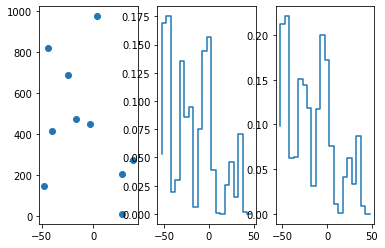

In [24]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,3)
axes[2].step(collector.binning[:-1], adcs2)
axes[1].step(collector.binning[:-1], adcs)
axes[0].scatter(depos[0, :, 1], depos[0, :, 0])

Above shows (a) the original depo locations in x vs y prior to drifting to x=0, and (b) the "ADC" per channel for drift model 1 and (c) same for drift model 2.  Model 2 should have less absorption and more diffusion (higher, wider peaks) compared to model 1.

Next we use model 1 as "reality" and starting with model 2, we optimize parameters so model 2 produces the same output as model 1.

In [21]:
nper = 10
batch_size = 100
nevent = batch_size * 1000
pachinko.test_train(batch_size=batch_size, learning_rate=0.01, num_workers=4, nevent=nevent, nper=nper)

parameter: ('0.param_dt', Parameter containing:
tensor(-3.8918, requires_grad=True))
parameter: ('0.param_lt', Parameter containing:
tensor(-1.3863, requires_grad=True))
Epoch 1
-------------------------------
loss: 4.386008  [    0/100000] DT:0.019992321729660034 lt:1998.697509765625
loss: 4.536621  [ 1000/100000] DT:0.019913198426365852 lt:1984.1219482421875
loss: 4.447999  [ 2000/100000] DT:0.019837062805891037 lt:1970.2200927734375
loss: 4.261790  [ 3000/100000] DT:0.019759679213166237 lt:1956.095947265625
loss: 4.296570  [ 4000/100000] DT:0.019681336358189583 lt:1941.6905517578125
loss: 4.257579  [ 5000/100000] DT:0.019603507593274117 lt:1927.5601806640625
loss: 4.457283  [ 6000/100000] DT:0.019525231793522835 lt:1913.377685546875
loss: 4.445351  [ 7000/100000] DT:0.019447261467576027 lt:1899.2171630859375
loss: 4.238019  [ 8000/100000] DT:0.019370554015040398 lt:1885.049072265625
loss: 4.362733  [ 9000/100000] DT:0.01929168775677681 lt:1870.478271484375
loss: 4.379732  [10000/100

loss: 4.084260  [ 5000/100000] DT:0.01170305348932743 lt:626.8382568359375
loss: 4.254307  [ 6000/100000] DT:0.011631036177277565 lt:618.2254028320312
loss: 4.243052  [ 7000/100000] DT:0.011559631675481796 lt:609.7513427734375
loss: 4.045904  [ 8000/100000] DT:0.01148973684757948 lt:601.3585815429688
loss: 4.164317  [ 9000/100000] DT:0.011419082060456276 lt:592.9429931640625
loss: 4.180742  [10000/100000] DT:0.011349348351359367 lt:584.8377075195312
loss: 4.136419  [11000/100000] DT:0.01127866841852665 lt:576.722900390625
loss: 4.199540  [12000/100000] DT:0.011208661831915379 lt:568.8057250976562
loss: 4.226653  [13000/100000] DT:0.011139674112200737 lt:561.039794921875
loss: 4.170915  [14000/100000] DT:0.011071601882576942 lt:553.3719482421875
loss: 4.224589  [15000/100000] DT:0.011002637445926666 lt:545.8364868164062
loss: 4.212338  [16000/100000] DT:0.010934557765722275 lt:538.3056640625
loss: 4.068378  [17000/100000] DT:0.010867868550121784 lt:530.9064331054688
loss: 4.188598  [180

loss: 4.102849  [13000/100000] DT:0.0067055560648441315 lt:221.4866943359375
loss: 4.040861  [14000/100000] DT:0.0066814422607421875 lt:220.38360595703125
loss: 4.098044  [15000/100000] DT:0.006656629499047995 lt:219.3140106201172
loss: 4.088524  [16000/100000] DT:0.006632794160395861 lt:218.22982788085938
loss: 3.943760  [17000/100000] DT:0.006609006784856319 lt:217.12986755371094
loss: 4.073657  [18000/100000] DT:0.006586061324924231 lt:216.09579467773438
loss: 3.876186  [19000/100000] DT:0.006562433671206236 lt:215.05287170410156
loss: 4.151668  [20000/100000] DT:0.006539367139339447 lt:214.03497314453125
loss: 3.906214  [21000/100000] DT:0.006516884546726942 lt:213.0421600341797
loss: 4.090135  [22000/100000] DT:0.006494422908872366 lt:212.08377075195312
loss: 4.166822  [23000/100000] DT:0.006471989676356316 lt:211.11151123046875
loss: 4.147274  [24000/100000] DT:0.006450617220252752 lt:210.15615844726562
loss: 3.998282  [25000/100000] DT:0.006428218446671963 lt:209.2248077392578
l

The above **should** convervge to the "reality" values of `DT=0.01` and `lifetime=3000`...